# Relevamiento del tiempo de Subida

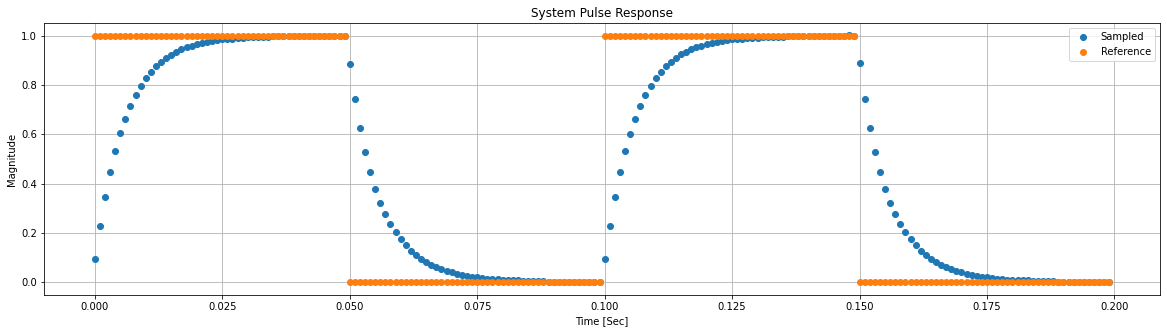

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000
SQ_WAVE_F_HZ = 10
SAMPLES_PER_PERIOD = SR_F_HZ // SQ_WAVE_F_HZ

# Cargamos los datos.
data = pd.read_csv('csvs/step_resp.csv')

# Ploteamos dos ciclos.
plt.figure(figsize=(20, 5))
plt.plot(data['Time'][:SAMPLES_PER_PERIOD * 2], data['ADC'][:SAMPLES_PER_PERIOD*2], 'o', label='Sampled')
plt.plot(data['Time'][:SAMPLES_PER_PERIOD * 2], data['DAC'][:SAMPLES_PER_PERIOD * 2], 'o', label='Reference')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()
plt.grid()

t_r = 13.0 ms


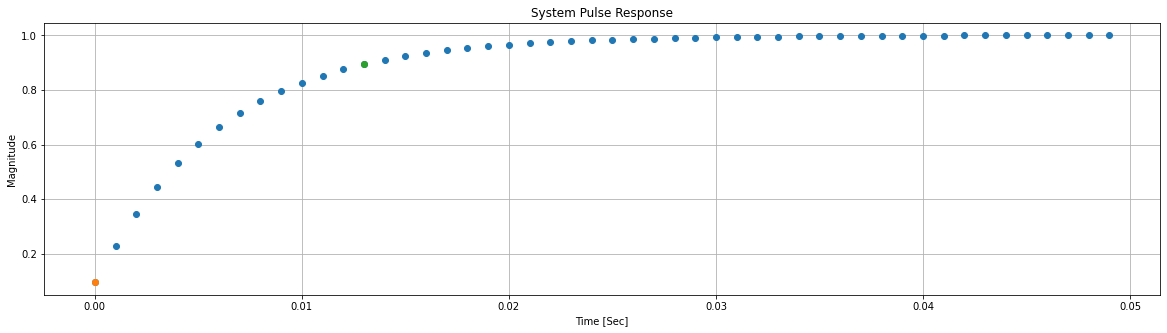

In [15]:
# Calculamos los límites para el risetime.
v10 = (data['ADC'].max())*.1
v90 = (data['ADC'].max())*.9

# Buscamos los instantes en los que ocurren.
t10_i = (data['ADC'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v10).abs().argmin()
t90_i = (data['ADC'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v90).abs().argmin()

# Graficamos.
plt.figure(figsize=(20, 5))
plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['ADC'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], 'o')
plt.plot(data['Time'][t10_i], data['ADC'][t10_i], 'o')
plt.plot(data['Time'][t90_i], data['ADC'][t90_i], 'o')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()

# Calculamos el Risetime.
tr = abs(data['Time'][t90_i] - data['Time'][t10_i])
print(f't_r = {tr * 1000} ms')

# Identificación de Coeficientes (LS)
* Se utilizó el algoritmo de LS en la EDU-CIAA
* El tiempo de sampleo y actualizacion del DAC se fijó en 10ms
* El período de actualización del algoritmo también se fijó en 10ms
* Se eligió un tamaño de filtro orden 2:
  * 3 Coeficientes que multiplican a la entrada: $b_o$, $b_1$ y $b_2$
  * 2 Coeficientes que multiplican a las salidas: $a_1$ y $a_2$
  * $a_o$ se toma como 1 para la constucción del modelo
* Señal de entrada: PRBS:
  * Generada a partir de la función `rand()` de la librería estandar de C
  * El valor de la señal se actualiza cada 10ms
  * Los valores del DAC varían entre 0 y 3v3: su rango completo

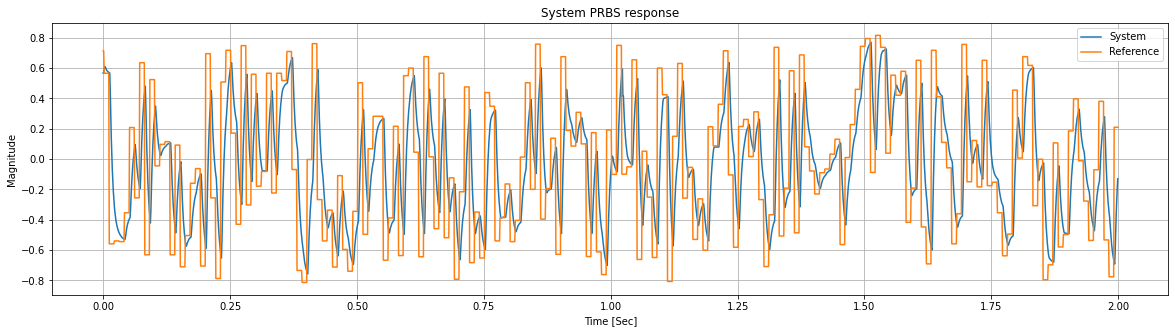

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000

# Datos capturados de la respuesta del sistema a la señal PRBS.
data2 = pd.read_csv('csvs/ls_output_data.csv')
plt.figure(figsize=(20, 5))
plt.plot(data2[:2000]['Time'], data2[:2000]['ADC'], label='System')
plt.plot(data2[:2000]['Time'], data2[:2000]['DAC'], label='Reference')
plt.grid()
plt.title('System PRBS response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()


Polo Teórico S 0: 362.997Hz
Polo Teórico S 1: 34.891Hz
Polo Teórico Z 0: 401.571Hz
Polo Teórico Z 1: 51.102Hz
Polo Empírico 0: 416.441Hz
Polo Empírico 1: 139.366Hz


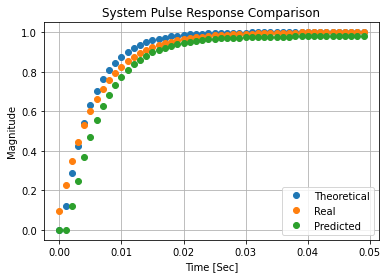

In [17]:
import numpy as np
from scipy.linalg import expm
from control import *
import matplotlib.pyplot as plt
from scipy import signal

## Sistema Teórico

# Componentes
r_1, c_1, r_2, c_2 = 10e3, 100e-9, 10e3, 200e-9

# Transferencia teórica
s = tf('s')
hs_1 = 1 / ((r_1*c_1*r_2*c_2)*s*s + (r_1*c_1+r_1*c_2+r_2*c_2)*s + 1)
num_1, den_1 = tfdata(hs_1)

# Polos
for i, pole_hz in enumerate(poles(hs_1) / (2*np.pi)):
    print(f'Polo Teórico S {i}: {float(-pole_hz.real):.3f}Hz')

# Transferencia teórica discretizada
hz_1 = c2d(hs_1, 1/SR_F_HZ, 'zoh')
numz_1, denz_1 = tfdata(hz_1)
ss_2 = tf2ss(numz_1, denz_1)
for i, pole_hz in enumerate((poles(hz_1) * SR_F_HZ / 2)):
    print(f'Polo Teórico Z {i}: {float(pole_hz.real):.3f}Hz')


# Transferencia reconstruida por LS del modelo
knum = [-3.58746428e-05, 5.19713034e-04, 1.17608695e-01]
den = [1, -1.11161405, 0.23215067]
rls_tf = tf(np.array(knum), np.array(den), dt=1/SR_F_HZ)
ss_rls = tf2ss(rls_tf) 
for i, pole_hz in enumerate(poles(rls_tf)* SR_F_HZ / 2):
    print(f'Polo Empírico {i}: {float(pole_hz.real):.3f}Hz')

# Comparamos la respuesta al escalón con las anteriores
t, hz_out = step_response(hz_1)
t_rls, hz_out_rls = step_response(ss_rls, T=0.01)
s = signal.lfilter(knum, den, data['DAC'][:SR_F_HZ//SQ_WAVE_F_HZ//2])
plt.plot(t[:SR_F_HZ//SQ_WAVE_F_HZ//2], hz_out[:SR_F_HZ//SQ_WAVE_F_HZ//2], 'o', label='Theoretical')
plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['ADC'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], 'o', label='Real')
plt.plot(t[:SR_F_HZ//SQ_WAVE_F_HZ//2], s, 'o', label='Predicted')
plt.grid()
plt.title('System Pulse Response Comparison')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

## Selección del Tiempo de Muestreo 
Para la selección del tiempo de muestreo se realizaron primero dos mediciones
de performance en el código. Dichas mediciones se realizaron utilizando el 
contador de ciclos de clock de la EDU-CIAA a fines de maximizar la precisión
de las mediciones. Para visualizar los resultados sin realentizar el loop 
principal, se ha utilizado el debugger para frenar la ejecución del programa
inmediatamente después de la medición temporal, tomando nota de la diferencia
del valor del contador respecto al inicio del lazo.

La primera medición se realizó en el loop principal del programa `pid_app` sin
transferir datos por puerto serie. La segunda medicion se realizó en el mismo
programa, incluyendo la transferencia de datos.

In [18]:
loop_period = 1 / SR_F_HZ
loop_cycles = 20400
non_uart_loop_cycles = 2820  # This includes ADC + DAC + PID Compute
with_uart_loop_cycles = 11474

def cycles_to_ms(cycles):
    return (cycles * loop_period) * 1000 / loop_cycles

print(f'Without UART: {cycles_to_ms(non_uart_loop_cycles)} ms')
print(f'With UART: {cycles_to_ms(with_uart_loop_cycles)} ms')

min_sampling_time = cycles_to_ms(with_uart_loop_cycles)
print(f'Min sampling time with UART: {min_sampling_time} ms')


target_samples_per_trise = 6  # Between 4 and 20 is Ok.

trise_s = 13e-3 
target_trise = trise_s * 0.7
th_min = target_trise / target_samples_per_trise
print(f'Max sampling time: {th_min * 1000}ms')


Without UART: 0.13823529411764707 ms
With UART: 0.5624509803921569 ms
Min sampling time with UART: 0.5624509803921569 ms
Max sampling time: 1.5166666666666664ms


Para poder capturar los resultados de salida, se considera el tiempo del lazo
de sistema _con_ la UART reportando datos. Esto degrada considerablemente el 
tiempo del lazo principal, pero dado que el alumno no cuenta con un osciloscopio
para medir la respuesta, no utilizar la UART para reporte de datos no es opción.

Así y todo, sampleando a 1ms es posible capturar más de 6 muestras de las
transiciones de la señal a lazo cerrado, y dejando libre aproximadamente el 
50% de la ventana de computo que tiene el programa entre dos instantes de 
actuacion consecutivos (1ms).


## Control PID 

In [19]:
from dataclasses import dataclass, field

@dataclass
class PIDController:
    kp: float
    ki: float
    kd: float
    h: float        # Discrete period
    n: float 
    b: float = 1.0  # Input conversion
    past_d: float = field(init=False, default=0)
    past_y: float = field(init=False, default=0)
    future_i: float = field(init=False, default=0)

    def compute(self, r, y) -> float:
        p = self.kp * (self.b * r - y)
        i = self.future_i 
        d = (self.kd / (self.kd + self.n * self.h)) * (self.past_d - self.n * (y - self.past_y))
                
        self.future_i = i + self.ki * self.h * (r - y)
        self.past_d = d
        self.past_y = y

        return p + i + d

def pid_controller_response(num: np.ndarray, den: np.ndarray, input: np.ndarray, pid_controller: PIDController) -> np.ndarray:
    
    a = np.array(den).flatten()
    b = np.array(num).flatten()
    
    n_inicial = len(a) - 1
    
    y = np.zeros(len(input) + n_inicial)
    r = np.concatenate((np.zeros(n_inicial), input), axis=None)
    u = np.concatenate((np.zeros(n_inicial), input), axis=None)
    
    for k in range(n_inicial, len(r)):
      u[k] = pid_controller.compute(r[k], y[k-1]) 

      for m in range(0, len(b)):
        y[k] = y[k] + b[m] * u[k-m]
      
      for n in range(1, len(a)):
        y[k] = y[k] - a[n] * y[k-n]
    
      y[k] = y[k] / a[0]

    return y[n_inicial-1:]


In [20]:
import numpy as np
import control as cnt
from scipy.linalg import expm
import matplotlib.pyplot as plt
SR_F_HZ = 1000

h = 1/SR_F_HZ
numz = [-3.58746428e-05, 5.19713034e-04, 1.17608695e-01]
denz = [1, -1.11161405, 0.23215067]
hz = cnt.tf(numz, denz, dt=h)


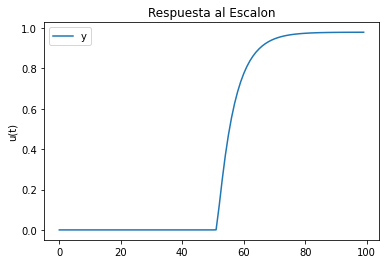

In [21]:
t = np.linspace(h, h * 100, 100)
u = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None)
t_hz_1, y_hz_1 = cnt.forced_response(hz, t, u)
p_1 = plt.plot(y_hz_1)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend('y(t)')

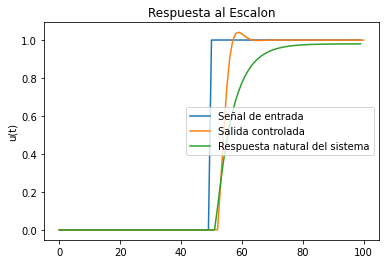

In [22]:
t = np.linspace(h, h * 100, 100)
r = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None)

pid = PIDController(kp=1.0 ,ki=0.0/h, kd=0.5*h, h=h, n=20, b=2.02)
y_hz_pid = pid_controller_response(numz, denz, r, pid)
t_hz_open, y_hz_open = cnt.forced_response(hz, t, r)

p_1 = plt.plot(r)
p_2 = plt.plot(y_hz_pid)
p_3 = plt.plot(y_hz_open)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend((p_1[0], p_2[0], p_3[0]), ('Señal de entrada', 'Salida controlada', 'Respuesta natural del sistema'));


In [23]:
overshoot = (max(y_hz_pid)/max(r) - 1) * 100
print(f'Overshoot: {overshoot}%')

Overshoot: 4.092828802748616%


In [26]:
def calculater_rise_time(sig, t=None, ref=1):
    t = t if t is not None else list(range(len(sig)))
    ths = [np.argmax(sig >= th * ref) for th in (.1, .9)]
    return t[ths[1]] - t[ths[0]]

r1 = calculater_rise_time(y_hz_open)
r2 = calculater_rise_time(y_hz_pid)
print(f'Rise Time Improvement (simulation) {(1 - r2/r1)*100}%')

Rise Time Improvement (simulation) 78.57142857142857%


In [25]:
## TODO: Adjust parameters in MCU.